<a href="https://colab.research.google.com/github/Frexicane/Python/blob/main/Combining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
espeak is already the newest version (1.48.15+dfsg-3).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


<IPython.core.display.Javascript object>

Starting live video feed. Click on the video to stop.
Ask a question about the current frame (or type "exit" to quit): 
what is going on?


>  The person in the photo is making a peace sign.

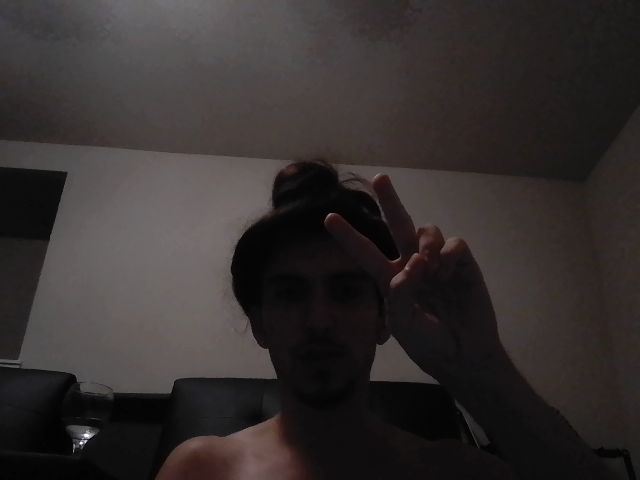

In [ ]:
!apt-get install -y espeak

import cv2
import numpy as np
import PIL
from IPython.display import display, Javascript, Image, Markdown
from google.colab.output import eval_js
from base64 import b64decode
import textwrap
import google.generativeai as genai
from google.colab import userdata
import pyttsx3

# Helper function to convert JavaScript object to OpenCV image
def js_to_image(js_reply):
    """Convert JavaScript object into an OpenCV image."""
    image_bytes = b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    return img

# Function to format text to Markdown
def to_markdown(text):
    """Format text to markdown."""
    text = text.replace('•', '  *')  # Adjust as per your formatting needs
    return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
    js = Javascript('''
        var video;
        var div = null;
        var stream;
        var captureCanvas;
        var imgElement;

        var pendingResolve = null;
        var shutdown = false;

        function removeDom() {
            stream.getVideoTracks()[0].stop();
            video.remove();
            div.remove();
            video = null;
            div = null;
            stream = null;
            imgElement = null;
            captureCanvas = null;
        }

        function onAnimationFrame() {
            if (!shutdown) {
                window.requestAnimationFrame(onAnimationFrame);
            }
            if (pendingResolve) {
                var result = "";
                if (!shutdown) {
                    captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
                    result = captureCanvas.toDataURL('image/jpeg', 0.8)
                }
                var lp = pendingResolve;
                pendingResolve = null;
                lp(result);
            }
        }

        async function createDom() {
            if (div !== null) {
                return stream;
            }

            div = document.createElement('div');
            div.style.border = '2px solid black';
            div.style.padding = '3px';
            div.style.width = '100%';
            div.style.maxWidth = '600px';
            document.body.appendChild(div);

            video = document.createElement('video');
            video.style.display = 'block';
            video.width = div.clientWidth - 6;
            video.setAttribute('playsinline', '');
            video.onclick = () => { shutdown = true; };
            stream = await navigator.mediaDevices.getUserMedia(
                {video: { facingMode: "environment"}});
            div.appendChild(video);

            imgElement = document.createElement('img');
            imgElement.style.position = 'absolute';
            imgElement.style.zIndex = 1;
            imgElement.onclick = () => { shutdown = true; };
            div.appendChild(imgElement);

            const instruction = document.createElement('div');
            instruction.innerHTML =
                '<span style="color: red; font-weight: bold;">' +
                'Type "Exit" to exit the program';
            div.appendChild(instruction);
            instruction.onclick = () => { shutdown = true; };

            video.srcObject = stream;
            await video.play();

            captureCanvas = document.createElement('canvas');
            captureCanvas.width = 640;
            captureCanvas.height = 480;
            window.requestAnimationFrame(onAnimationFrame);

            return stream;
        }
        async function stream_frame(label) {
            if (shutdown) {
                removeDom();
                shutdown = false;
                return '';
            }

            var preCreate = Date.now();
            stream = await createDom();

            var preShow = Date.now();

            var preCapture = Date.now();
            var result = await new Promise(function(resolve, reject) {
                pendingResolve = resolve;
            });
            shutdown = false;

            return {'create': preShow - preCreate,
                    'show': preCapture - preShow,
                    'capture': Date.now() - preCapture,
                    'img': result};
        }
    ''')
    display(js)

# Function to detect floor and draw path
def detect_floor_and_draw_path(img):
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Perform edge detection or other suitable techniques to detect the floor
    # Example: Canny edge detection (adjust parameters based on your environment)
    edges = cv2.Canny(gray, 50, 150)

    # Find contours of potential floor regions
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Draw the contours on the original image (dummy example, replace with actual path drawing logic)
    cv2.drawContours(img, contours, -1, (0, 0, 255), 2)

    return img

# Function to detect path-related questions
def is_path_question(question):
    path_keywords = ["route", "path", "road", "way"]
    return any(keyword in question.lower() for keyword in path_keywords)

# Setup API key for generative AI
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

# Setup model (adjust model name as per availability)
model = genai.GenerativeModel('gemini-pro-vision')

# Initialize pyttsx3 TTS engine
tts_engine = pyttsx3.init()

# Configure properties
voices = tts_engine.getProperty('voices')
# Set the voice. You can choose a different index based on available voices.
tts_engine.setProperty('voice', voices[0].id)
# Set the speech rate (speed). Default is 200 (words per minute).
tts_engine.setProperty('rate', 150)
# Set the volume (0.0 to 1.0)
tts_engine.setProperty('volume', 1.0)

# Start streaming video from webcam
video_stream()

# Continuous video feed
print("Starting live video feed. Click on the video to stop.")

# Loop to handle questions
while True:
    # Wait for user question
    userQuestion = input('Ask a question about the current frame (or type "exit" to quit): \n')

    if userQuestion.lower() == "exit":
        break

    # Capture the current frame
    js_reply = eval_js('stream_frame("")')

    if not js_reply:
        break

    # Convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # Convert the image to RGB mode to remove the alpha channel
    image_rgb = PIL.Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)).convert('RGB')

    # Check if the question is about a path
    if is_path_question(userQuestion):
        # Detect floor and draw path
        img = detect_floor_and_draw_path(img)

    # Generate content based on the question and image
    response = model.generate_content([userQuestion, image_rgb], safety_settings=[
        {
            "category": "HARM_CATEGORY_HARASSMENT",
            "threshold": "BLOCK_NONE",
        },
        {
            "category": "HARM_CATEGORY_HATE_SPEECH",
            "threshold": "BLOCK_NONE",
        },
        {
            "category": "HARM_CATEGORY_DANGEROUS",
            "threshold": "BLOCK_NONE",
        }
    ])

    try:
        response.resolve()
        display(to_markdown(response.text))
        display(PIL.Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))

        # Get the AI response as a string
        ai_response = response.text

        # Speak the AI response
        tts_engine.say(ai_response)
        tts_engine.runAndWait()

    except ValueError as e:
        print("Error generating content:", e)
        print("The response may have been blocked due to safety settings. Please try a different question.")

